In [63]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # use Agg backend for matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [64]:
raw = pd.read_csv('AmesHousing.csv')

In [65]:
data = raw.copy()

In [66]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [67]:
object_cols = data.select_dtypes(include='object').columns
print(object_cols)

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object')


In [68]:
data['MS Zoning'].unique()

array(['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)'],
      dtype=object)

In [69]:
zoning_impact = {
    'I (all)': 1,    # Industrial, usually lowest prices
    'C (all)': 2,    # Commercial, medium/variable
    'A (agr)': 3,    # Agricultural, medium
    'RM': 4,         # Residential medium density
    'RH': 5,         # Residential high density
    'FV': 6,         # Floating village / planned residential
    'RL': 7          # Residential low density, usually highest
}

In [70]:
data['MS Zoning'] = data['MS Zoning'].map(zoning_impact)

In [71]:
data = data.set_index('Order')
data

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
Order,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,7,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
2,526350040,20,5,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
3,526351010,20,7,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
4,526353030,20,7,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
5,527105010,60,7,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,923275080,80,7,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2927,923276100,20,7,NaN,8885,Pave,NaN,IR1,Low,AllPub,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2928,923400125,85,7,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000


In [72]:
data['Neighborhood'].unique()

array(['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'Somerst', 'BrDale',
       'NPkVill', 'NridgHt', 'Blmngtn', 'NoRidge', 'SawyerW', 'Sawyer',
       'Greens', 'BrkSide', 'OldTown', 'IDOTRR', 'ClearCr', 'SWISU',
       'Edwards', 'CollgCr', 'Crawfor', 'Blueste', 'Mitchel', 'Timber',
       'MeadowV', 'Veenker', 'GrnHill', 'Landmrk'], dtype=object)

In [73]:
avg_price_neighd = data.groupby('Neighborhood')['SalePrice'].mean()
data['Average Price Per Neighborhood'] = data['Neighborhood'].map(round(avg_price_neighd))


In [74]:
data['Utilities'].unique()

array(['AllPub', 'NoSewr', 'NoSeWa'], dtype=object)

In [75]:
data['SalePrice']

Order
1       215000
2       105000
3       172000
4       244000
5       189900
         ...  
2926    142500
2927    131000
2928    132000
2929    170000
2930    188000
Name: SalePrice, Length: 2930, dtype: int64

In [76]:
column_reordered = ['PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage',
       'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area',
       'Pool QC', 'Fence', 'Misc Feature', 'Misc Val', 'Mo Sold',
       'Yr Sold', 'Sale Type', 'Sale Condition', 
       'Average Price Per Neighborhood', 'SalePrice']

In [77]:
data = data[column_reordered]

In [78]:
data['Average Price Per Neighborhood']

Order
1       145097.0
2       145097.0
3       145097.0
4       145097.0
5       190647.0
          ...   
2926    162227.0
2927    162227.0
2928    162227.0
2929    162227.0
2930    162227.0
Name: Average Price Per Neighborhood, Length: 2930, dtype: float64

In [79]:
data = data.drop('Alley', axis = 1)
data = data.drop('PID', axis = 1)

In [80]:
data.shape

(2930, 80)

In [81]:
data.isna().sum()

MS SubClass                         0
MS Zoning                           0
Lot Frontage                      490
Lot Area                            0
Street                              0
                                 ... 
Yr Sold                             0
Sale Type                           0
Sale Condition                      0
Average Price Per Neighborhood      0
SalePrice                           0
Length: 80, dtype: int64

In [82]:
null_counts = data.isnull().sum()
columns_null_value = null_counts[null_counts > 4].index

In [83]:
columns_null_value

Index(['Lot Frontage', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
       'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish',
       'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature'],
      dtype='object')

In [84]:
data.columns.values

array(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2',
       'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond',
       'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'Garage Finish', 'Garage

In [85]:
data = data.drop(columns=columns_null_value)

In [86]:
data.dropna(inplace = True)

In [87]:
data.shape

(2926, 63)

In [88]:
data['Sale Condition'].unique()

array(['Normal', 'Partial', 'Family', 'Abnorml', 'Alloca', 'AdjLand'],
      dtype=object)

In [89]:
data[['Exter Cond', 'Exter Qual']]

,Exter Cond,Exter Qual
Order,,
1,TA,TA
2,TA,TA
3,TA,TA
4,TA,Gd
5,TA,TA
...,...,...
2926,TA,TA
2927,TA,TA
2928,TA,TA


In [90]:
bldg_type_dummies = pd.get_dummies(data['Bldg Type'], prefix='BldgType').astype(int)
data = pd.concat([data, bldg_type_dummies], axis=1)
data = data.drop('Bldg Type', axis=1)


In [ ]:
kitchen_qual_dict = {
    'Po': 1,   # Poor
    'Fa': 2,   # Fair
    'TA': 3,   # Typical/Average
    'Gd': 4,   # Good
    'Ex': 5    # Excellent
}
utilities_dict = {
    'NoSewr': 1,   # No sewer
    'NoSeWa': 2,   # No sewer & no water
    'AllPub': 3    # All public utilities (water, sewer, electricity)
}
heating_qc_dict = {
    'Po': 1,   # Poor
    'Fa': 2,   # Fair
    'TA': 3,   # Typical/Average
    'Gd': 4,   # Good
    'Ex': 5    # Excellent
}
house_style_dict = {
    '1.5Unf': 1,   # 1.5 stories, unfinished
    '2.5Unf': 2,   # 2.5 stories, unfinished
    'SLvl': 3,      # Split-level
    'SFoyer': 4,    # Split foyer
    '1Story': 5,    # Single story
    '1.5Fin': 6,    # 1.5 stories, finished
    '2Story': 7,    # 2 stories
    '2.5Fin': 8     # 2.5 stories, finished
}
central_air_dict = {'N': 0, 'Y': 1}

roof_style_impact = {
    'Flat': 1,      # Usually the least expensive, often for commercial or modern minimal designs
    'Shed': 2,      # Simple single-slope roof
    'Gable': 3,     # Common and moderately priced
    'Hip': 4,       # More complex structure, better aesthetics, slightly higher cost
    'Gambrel': 5,   # Classic barn-style, more unique and costly
    'Mansard': 6    # Most complex and stylish, higher construction cost
}
land_slope_impact = {
    'Sev': 1,   # Severe slope → lower price
    'Mod': 2,   # Moderate slope
    'Gtl': 3    # Gentle slope → higher price
}
condition_1_impact = {
    'Norm': 5,   # Normal → highest price
    'PosA': 4,   # Positive access? Slightly favorable
    'PosN': 3,   # Positive near? Neutral/fair
    'Artery': 2, # Near arterial road → lower
    'Feedr': 2,  # Near feeder road → lower
    'RRNn': 1,   # Near railroad → lowest
    'RRNe': 1,
    'RRAe': 1,
    'RRAn': 1
}
condition_2_impact = {
    'Norm': 5,   # Normal → highest price
    'PosA': 4,   # Slightly favorable
    'PosN': 3,   # Neutral/fair
    'Artery': 2, # Near arterial road → lower
    'Feedr': 2,  # Near feeder road → lower
    'RRNn': 1,   # Near railroad → lowest
    'RRAe': 1,
    'RRAn': 1
}
roof_matl_map = {
    'ClyTile': 6,   # high quality, expensive
    'CompShg': 5,   # common asphalt shingles
    'WdShngl': 4,   # wood shingles
    'WdShake': 4,   # similar to wood shingles
    'Metal': 3,     # moderate quality
    'Membran': 2,   # flat roof membranes
    'Tar&Grv': 2,   # older style tar and gravel
    'Roll': 1       # lowest quality
}
sale_type_map = {
    'Oth': 1,      # other / miscellaneous
    'COD': 2,      # court-ordered
    'ConLw': 3,    # contract low
    'ConLD': 4,    # contract low dated
    'ConLI': 5,    # contract low immediate
    'Con': 6,      # normal contract
    'VWD': 7,      # very weak deed
    'CWD': 8,      # conventional warranty deed
    'WD ': 9,      # standard warranty deed
    'New': 10      # new construction usually higher
}
exterior_1st_map = {
    'AsphShn': 1,     # asphalt shingles / cheap
    'Plywood': 2,
    'Wd Sdng': 3,     # wood siding
    'HdBoard': 4,     # hardboard
    'VinylSd': 5,     # vinyl siding
    'CemntBd': 6,     # cement board
    'MetalSd': 7,     # metal siding
    'AsbShng': 8,     # asbestos shingles
    'Stucco': 9,
    'WdShing': 10,    # wood shingles
    'BrkFace': 11,    # brick face
    'BrkComm': 12,    # commercial brick
    'Stone': 13,
    'CBlock': 14,     # concrete block
    'PreCast': 15,    # precast concrete
    'ImStucc': 16     # improved stucco / high quality
}
exterior_2nd_map = {
    'AsphShn': 1,     # asphalt shingles / low quality
    'Plywood': 2,
    'Wd Sdng': 3,     # wood siding
    'HdBoard': 4,     # hardboard
    'VinylSd': 5,     # vinyl siding
    'CmentBd': 6,     # cement board
    'MetalSd': 7,     # metal siding
    'AsbShng': 8,     # asbestos shingles
    'Stucco': 9,
    'Wd Shng': 10,    # wood shingles
    'BrkFace': 11,    # brick face
    'Brk Cmn': 12,    # commercial brick
    'Stone': 13,
    'CBlock': 14,     # concrete block
    'PreCast': 15,    # precast concrete
    'ImStucc': 16,    # improved stucco
    'Other': 0        # unknown/other material
}
exter_qual_map = {
    'Fa': 1,   # Fair
    'TA': 2,   # Typical/Average
    'Gd': 3,   # Good
    'Ex': 4    # Excellent
}
# Define mapping from low to high
exter_cond_map = {
    'Po': 1,  # Poor
    'Fa': 2,  # Fair
    'TA': 3,  # Typical/Average
    'Gd': 4,  # Good
    'Ex': 5   # Excellent
}
# Define mapping from low to high
exter_qual_map = {
    'Fa': 1,  # Fair
    'TA': 2,  # Typical/Average
    'Gd': 3,  # Good
    'Ex': 4   # Excellent
}
foundation_map = {
    'Slab': 1,    # Lowest quality / typical cost
    'Wood': 2,    # Less durable
    'Stone': 3,   # Moderate quality
    'BrkTil': 4,  # Brick/Tile, better quality
    'CBlock': 5,  # Concrete block
    'PConc': 6    # Poured concrete, highest quality
}
lot_config_map = {
    'FR3': 1,       # 3+ frontage roads, less desirable
    'FR2': 2,       # 2 frontage roads
    'Inside': 3,    # interior lot
    'CulDSac': 4,   # cul-de-sac, more desirable
    'Corner': 5     # corner lot, typically higher visibility/appeal
}
street_map = {
    'Grvl': 1,   # Gravel – less desirable
    'Pave': 2    # Paved – more desirable
}
lot_shape_map = {
    'Reg': 4,   # Regular – most desirable
    'IR1': 3,   # Slightly irregular
    'IR2': 2,   # Moderately irregular
    'IR3': 1    # Irregular – least desirable
}
land_contour_map = {
    'Lvl': 4,   # Level – most desirable
    'HLS': 3,   # Hillside – moderately desirable
    'Bnk': 2,   # Bank – less desirable
    'Low': 1    # Low – least desirable (risk of flooding)
}
heating_map = {
    'GasA': 6,   # Gas forced air – most common and efficient
    'GasW': 5,   # Gas hot water – fairly efficient
    'Grav': 4,   # Gravity furnace – older system
    'Wall': 3,   # Wall furnace – less desirable
    'Floor': 2,  # Floor furnace – less efficient
    'OthW': 1    # Other/wood or unknown – least desirable
}
electrical_map = {
    'SBrkr': 5,  # Standard circuit breaker – most desirable
    'FuseA': 4,  # Fuse type A – acceptable
    'FuseF': 3,  # Fuse type F – older/less reliable
    'FuseP': 2,  # Fuse type P – even older/less common
    'Mix': 1     # Mixed or unknown – least desirable
}
functional_map = {
    'Typ': 8,   # Typical – best/most functional
    'Mod': 7,   # Minor modifications
    'Min1': 6,  # Minor issues 1
    'Min2': 5,  # Minor issues 2
    'Maj1': 4,  # Major issues 1
    'Maj2': 3,  # Major issues 2
    'Sev': 2,   # Severe functional problems
    'Sal': 1    # Salvage only – worst
}
paved_drive_map = {
    'N': 0,  # No paved driveway
    'Y': 1,  # Partially paved
    'P': 2   # Fully paved
}
sale_condition_map = {
    'Normal': 6,    # Standard sale – most favorable
    'Partial': 5,   # Partially complete/financed – slightly less favorable
    'Family': 4,    # Sold to family/friend – moderate
    'Abnorml': 3,   # Abnormal sale – less favorable
    'Alloca': 2,    # Allocation – unusual
    'AdjLand': 1    # Land adjustment – least favorable
}

In [92]:
data['Kitchen Qual'] = data['Kitchen Qual'].map(kitchen_qual_dict)
data['Utilities'] = data['Utilities'].map(utilities_dict)
data['Heating QC'] = data['Heating QC'].map(heating_qc_dict)
data['House Style'] = data['House Style'].map(house_style_dict)
data['Central Air'] = data['Central Air'].map(central_air_dict)
data['Roof Style'] = data['Roof Style'].map(roof_style_impact)
data['Land Slope'] = data['Land Slope'].map(land_slope_impact)
data['Condition 1'] = data['Condition 1'].map(condition_1_impact)
data['Condition 2'] = data['Condition 2'].map(condition_2_impact)
data['Roof Matl'] = data['Roof Matl'].map(roof_matl_map)
data['Sale Type'] = data['Sale Type'].map(sale_type_map)
data['Exterior 1st'] = data['Exterior 1st'].map(exterior_1st_map)
data['Exterior 2nd'] = data['Exterior 2nd'].map(exterior_2nd_map)
data['Exter Qual'] = data['Exter Qual'].map(exter_qual_map)
data['Exter Cond'] = data['Exter Cond'].map(exter_cond_map)
data['Exter Qual'] = data['Exter Qual'].map(exter_qual_map)
data['Foundation'] = data['Foundation'].map(foundation_map)
data['Lot Config'] = data['Lot Config'].map(lot_config_map)
data['Street'] = data['Street'].map(street_map)
data['Lot Shape'] = data['Lot Shape'].map(lot_shape_map)
data['Land Contour'] = data['Land Contour'].map(land_contour_map)
data['Heating'] = data['Heating'].map(heating_map)
data['Electrical'] = data['Electrical'].map(electrical_map)
data['Functional'] = data['Functional'].map(functional_map)
data['Paved Drive'] = data['Paved Drive'].map(paved_drive_map)
data['Sale Condition'] = data['Sale Condition'].map(sale_condition_map)

In [93]:
data = data.drop('Neighborhood', axis =1)
data = data.drop('Exter Qual', axis =1)

In [94]:
object_cols = data.select_dtypes(include='object').columns
print(object_cols)

Index([], dtype='object')


In [95]:
data.columns.values

array(['MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
       'Condition 1', 'Condition 2', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Exter Cond',
       'Foundation', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area',
       'Misc Val', 'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition',
       'Average Price Per Neighborhood', 'Sal

In [96]:
drop_features = [
    "Utilities", "Street", "Pool Area", "Misc Val", "Condition 2",
    "Mo Sold", "Land Contour", "Land Slope",
    "BsmtFin SF 2",   # often very sparse
    "3Ssn Porch"      # almost always 0
]


In [97]:
# House age at the time of sale
data["House Age"] = data["Yr Sold"] - data["Year Built"]

# You might also want to drop the originals to avoid redundancy
data = data.drop(["Year Built", "Year Remod/Add", "Yr Sold"], axis=1)

data = data.drop(columns=drop_features)


In [98]:
data.head()

,MS SubClass,MS Zoning,Lot Area,Lot Shape,Lot Config,Condition 1,House Style,Overall Qual,Overall Cond,Roof Style,...,Sale Type,Sale Condition,Average Price Per Neighborhood,SalePrice,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,House Age
Order,,,,,,,,,,,,,,,,,,,,,
1,20,7,31770,3,5,5,5,6,5,4,...,9,6,145097.0,215000,1,0,0,0,0,50
2,20,5,11622,4,3,2,5,5,6,3,...,9,6,145097.0,105000,1,0,0,0,0,49
3,20,7,14267,3,5,5,5,6,6,4,...,9,6,145097.0,172000,1,0,0,0,0,52
4,20,7,11160,4,5,5,5,7,5,4,...,9,6,145097.0,244000,1,0,0,0,0,42
5,60,7,13830,3,3,5,7,5,5,3,...,9,6,190647.0,189900,1,0,0,0,0,13


In [99]:
data.columns.values

array(['MS SubClass', 'MS Zoning', 'Lot Area', 'Lot Shape', 'Lot Config',
       'Condition 1', 'House Style', 'Overall Qual', 'Overall Cond',
       'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Exter Cond', 'Foundation', 'BsmtFin SF 1', 'Bsmt Unf SF',
       'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', 'Screen Porch', 'Sale Type', 'Sale Condition',
       'Average Price Per Neighborhood', 'SalePrice', 'BldgType_1Fam',
       'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'House Age'], dtype=object)

In [100]:
X = sm.add_constant(data)
data_vif = pd.DataFrame()
data_vif['Features'] = X.columns
data_vif = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

c:\Users\spenc\ds_ml_environment\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\spenc\ds_ml_environment\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


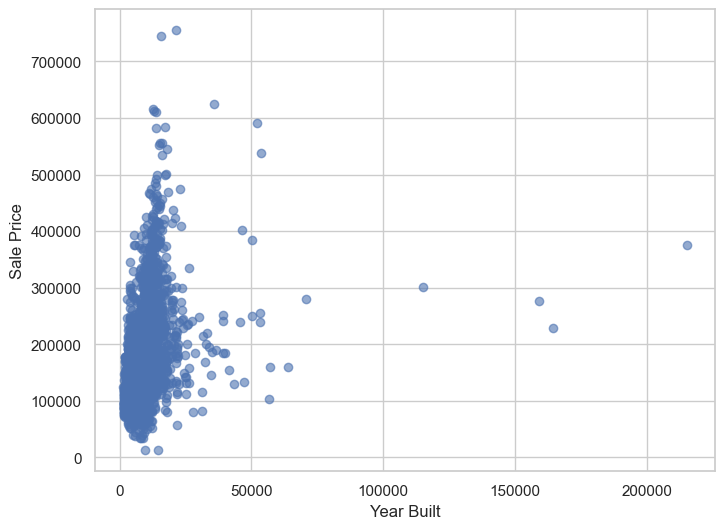

In [101]:
plt.figure(figsize=(8,6))
plt.scatter(data['Lot Area'], data['SalePrice'], alpha=0.6)
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.show()

<Axes: xlabel='SalePrice', ylabel='Count'>

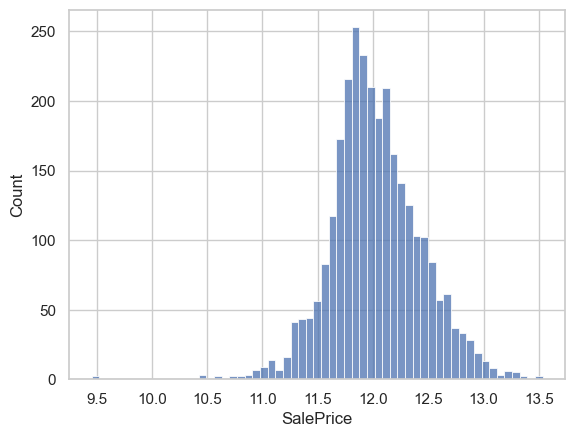

In [102]:
sns.histplot(np.log1p(data['SalePrice']))

In [103]:
Xnd = data.values  

X_scaled = StandardScaler().fit_transform(Xnd)

pca = PCA(n_components=32)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio of each component:", pca.explained_variance_ratio_)
print("Total variance captured:", pca.explained_variance_ratio_.sum())


Explained variance ratio of each component: [0.17265045 0.07351315 0.06163153 0.05273593 0.04061059 0.03694019
 0.0302528  0.02713715 0.02559482 0.02443116 0.02347967 0.02185036
 0.02092389 0.01963789 0.01957688 0.01911018 0.01826066 0.01809541
 0.01760312 0.01686158 0.01655114 0.01623807 0.01515514 0.01459441
 0.01402541 0.01383325 0.01265693 0.01248596 0.01220143 0.01169499
 0.01111753 0.0108195 ]
Total variance captured: 0.9022711715340068


In [104]:
Xnd_df = pd.DataFrame(Xnd, columns=data.columns)

loadings = pd.DataFrame(
    pca.components_.T,
    index=data.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32
MS SubClass,-0.026516,0.198376,-0.427413,0.081477,-0.151002,0.082936,0.019716,-0.171695,-0.066948,0.030018,...,0.047449,-0.049227,0.010193,0.021552,0.030980,-0.004060,-0.008709,0.039418,-0.017319,0.006511
MS Zoning,0.139500,-0.115332,0.123118,0.002854,-0.064983,-0.229087,-0.086909,0.246029,-0.017148,0.016064,...,0.117956,-0.205527,-0.267546,0.057842,0.422588,0.002872,0.076208,0.037518,-0.301265,0.056999
Lot Area,0.092672,-0.008259,0.229289,0.106423,-0.124806,0.050562,-0.129710,-0.022012,-0.138067,0.121505,...,-0.300363,-0.028582,0.445166,-0.006333,0.069020,-0.095004,0.228143,0.101222,0.130212,0.493118
Lot Shape,-0.119220,0.035843,-0.053288,0.011891,0.085856,0.050752,0.199432,-0.006461,0.161035,-0.233401,...,0.353743,0.125831,-0.035091,0.225378,0.220165,-0.007476,0.262014,0.215335,0.120522,0.393425
Lot Config,0.011412,0.011715,0.124889,0.029837,-0.011550,0.016810,-0.034900,-0.013278,-0.080792,0.238679,...,0.448525,0.035301,-0.098854,0.083624,-0.002428,-0.008872,0.049664,0.071235,0.077177,0.177155


In [105]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32
MS SubClass,-0.026516,0.198376,-0.427413,0.081477,-0.151002,0.082936,0.019716,-0.171695,-0.066948,0.030018,...,0.047449,-0.049227,0.010193,0.021552,0.030980,-0.004060,-0.008709,0.039418,-0.017319,0.006511
MS Zoning,0.139500,-0.115332,0.123118,0.002854,-0.064983,-0.229087,-0.086909,0.246029,-0.017148,0.016064,...,0.117956,-0.205527,-0.267546,0.057842,0.422588,0.002872,0.076208,0.037518,-0.301265,0.056999
Lot Area,0.092672,-0.008259,0.229289,0.106423,-0.124806,0.050562,-0.129710,-0.022012,-0.138067,0.121505,...,-0.300363,-0.028582,0.445166,-0.006333,0.069020,-0.095004,0.228143,0.101222,0.130212,0.493118
Lot Shape,-0.119220,0.035843,-0.053288,0.011891,0.085856,0.050752,0.199432,-0.006461,0.161035,-0.233401,...,0.353743,0.125831,-0.035091,0.225378,0.220165,-0.007476,0.262014,0.215335,0.120522,0.393425
Lot Config,0.011412,0.011715,0.124889,0.029837,-0.011550,0.016810,-0.034900,-0.013278,-0.080792,0.238679,...,0.448525,0.035301,-0.098854,0.083624,-0.002428,-0.008872,0.049664,0.071235,0.077177,0.177155
Condition 1,0.039108,-0.058971,-0.089848,-0.036405,0.038504,-0.028859,-0.040711,-0.041589,-0.122756,-0.173574,...,0.043613,0.122399,0.169597,-0.118535,0.062475,0.047890,-0.000854,0.041667,0.031117,-0.043037
House Style,0.068638,0.310436,-0.059048,-0.242106,-0.065922,0.065166,-0.094029,0.053168,0.056626,-0.052432,...,-0.021536,0.057481,0.078264,-0.014242,-0.122715,-0.077881,0.136399,0.058307,-0.074289,0.088893
Overall Qual,0.275018,-0.005375,-0.080659,-0.036169,0.072669,0.063259,0.048788,-0.084439,-0.001103,0.049312,...,-0.017517,-0.072918,-0.062391,0.074179,0.015367,-0.086794,-0.112718,-0.044835,-0.008931,-0.048872
Overall Cond,-0.065814,-0.034891,0.102867,-0.175766,-0.189187,0.103041,0.482753,-0.105151,-0.054224,0.171081,...,0.032749,0.000458,0.079402,0.002868,0.085593,-0.096174,-0.170136,-0.175359,0.056344,-0.113241
Roof Style,0.058734,-0.028441,0.063567,0.087866,0.073368,0.145461,0.155714,-0.066768,0.452099,-0.231297,...,0.059977,-0.135454,0.184043,0.172656,-0.070519,-0.333161,0.195121,-0.236302,-0.331267,0.084598


In [106]:
# Assuming you have PCA fitted as `pca` and your original feature names in `data.columns`
loadings = pd.DataFrame(
    pca.components_.T,  # transpose so features are rows
    index=data.columns, # original feature names
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Check top contributing features for first principal component
top_features_pc1 = loadings['PC1'].abs().sort_values(ascending=False)
print("Top features for PC1:")
print(top_features_pc1.head(10))

# Repeat for other PCs if needed
top_features_pc2 = loadings['PC2'].abs().sort_values(ascending=False)


Top features for PC1:
SalePrice                         0.299243
Overall Qual                      0.275018
Average Price Per Neighborhood    0.261161
Garage Cars                       0.249142
Gr Liv Area                       0.244163
Garage Area                       0.242083
Kitchen Qual                      0.233464
House Age                         0.232832
Total Bsmt SF                     0.228537
1st Flr SF                        0.214952
Name: PC1, dtype: float64


PC1 feature contributions:
SalePrice                         0.299243
Overall Qual                      0.275018
Average Price Per Neighborhood    0.261161
Garage Cars                       0.249142
Gr Liv Area                       0.244163
Garage Area                       0.242083
Kitchen Qual                      0.233464
Total Bsmt SF                     0.228537
1st Flr SF                        0.214952
Full Bath                         0.212301
Foundation                        0.191487
TotRms AbvGrd                     0.177971
Heating QC                        0.175463
Fireplaces                        0.163252
MS Zoning                         0.139500
BsmtFin SF 1                      0.138993
Central Air                       0.127807
Open Porch SF                     0.122961
Wood Deck SF                      0.121494
Half Bath                         0.114943
Electrical                        0.111445
2nd Flr SF                        0.093962
Lot Area                   

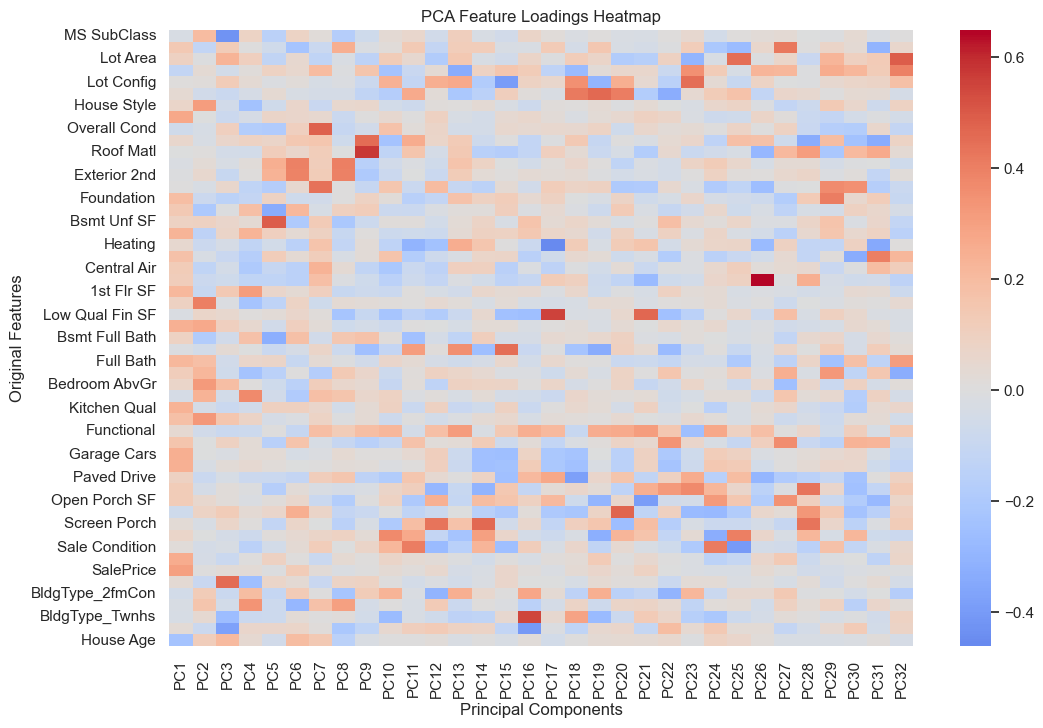

In [107]:
pc1_loadings = loadings['PC1'].sort_values(ascending=False)
print("PC1 feature contributions:")
print(pc1_loadings)

# Heatmap of all PC loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=False)
plt.title("PCA Feature Loadings Heatmap")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.show()


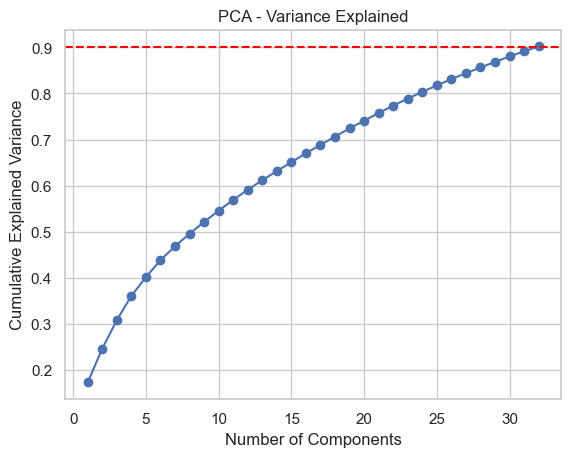

Components needed for 90% variance: 32


In [108]:
explained_var = np.array([pca.explained_variance_ratio_])

cumulative = np.cumsum(explained_var)

plt.plot(range(1, len(cumulative)+1), cumulative, marker='o')
plt.axhline(0.90, color='red', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Variance Explained")
plt.show()

print("Components needed for 90% variance:", np.argmax(cumulative >= 0.90) + 1)

In [109]:
from sklearn.model_selection import train_test_split

y = data['SalePrice'].values  

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Training set shape:", y_train.shape)
print("Testing set shape:", X_test.shape)
print("Testing set shape:", y_test.shape)


Training set shape: (2340, 32)
Training set shape: (2340,)
Testing set shape: (586, 32)
Testing set shape: (586,)


In [110]:
LinReg = LinearRegression()

In [111]:
results = LinReg.fit(X_train, y_train)

In [112]:
coeff = pd.Series(LinReg.coef_)
intercept = pd.Series(LinReg.intercept_)

print('The coefficients are: ', coeff)
print('The intercept is: ', intercept)

The coefficients are:  0     23887.897815
1      -198.034496
2      1875.253367
3      1890.911297
4      -955.369140
5      9702.286531
6      1966.800375
7     -1308.358074
8      -396.187058
9      2329.772811
10     1218.349852
11     4218.093377
12    -2744.548915
13    -1502.125691
14     5307.088143
15     1012.752598
16     -937.067144
17     2294.928023
18     4999.160072
19     1738.574996
20     6976.898310
21     -172.675624
22    -1499.088202
23    -1716.016708
24    -1647.332645
25     2731.744037
26      595.354693
27    -4260.124014
28    -3173.460215
29    -1510.751831
30     -746.836302
31      -45.587657
dtype: float64
The intercept is:  0    180672.815584
dtype: float64


In [113]:
summary_table = pd.DataFrame()
summary_table['Features'] = loadings.index
summary_table['Coefficients'] = coeff
summary_table.dropna(axis=0, inplace = True)
summary_table

,Features,Coefficients
0,MS SubClass,23887.897815
1,MS Zoning,-198.034496
2,Lot Area,1875.253367
3,Lot Shape,1890.911297
4,Lot Config,-955.369140
5,Condition 1,9702.286531
6,House Style,1966.800375
7,Overall Qual,-1308.358074
8,Overall Cond,-396.187058
9,Roof Style,2329.772811


In [114]:
# Define models and parameter grids
models = {
    'Lasso': {
        'model': Lasso(max_iter=5000),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Ridge': {
        'model': Ridge(max_iter=5000),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'ElasticNet': {
        'model': ElasticNet(max_iter=5000),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],
            'l1_ratio': [0.2, 0.5, 0.8]  # balance between Lasso and Ridge
        }
    }
}

best_models = {}

for name, mp in models.items():
    grid = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    
    # Predict on test set
    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: Best Params = {grid.best_params_}, Test MSE = {mse:.2f}")


Lasso: Best Params = {'alpha': 100}, Test MSE = 847560011.05
Ridge: Best Params = {'alpha': 100}, Test MSE = 848579036.94
ElasticNet: Best Params = {'alpha': 0.1, 'l1_ratio': 0.5}, Test MSE = 849161206.49


In [115]:
df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(X_pca.shape[1])],
    'Lasso': best_models['Lasso'].coef_,
    'Ridge': best_models['Ridge'].coef_,
    'ElasticNet': best_models['ElasticNet'].coef_
})


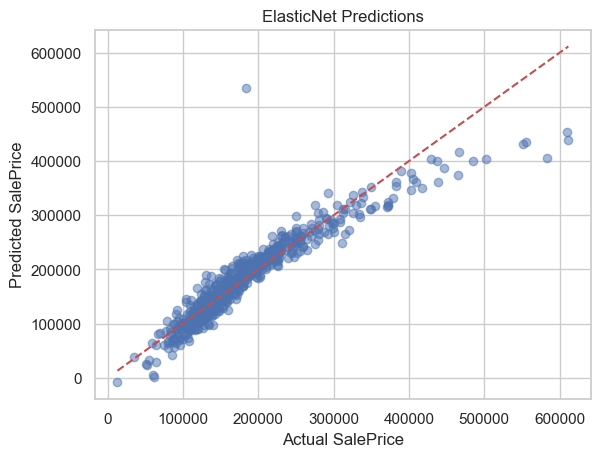

In [116]:
y_pred = best_models['ElasticNet'].predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('ElasticNet Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


In [117]:
from sklearn.linear_model import LinearRegression

lasso_orig_coef = pca.components_.T @ best_models['Lasso'].coef_
ridge_orig_coef = pca.components_.T @ best_models['Ridge'].coef_
elastic_orig_coef = pca.components_.T @ best_models['ElasticNet'].coef_


# Project coefficients back to original feature space
linreg_orig_coef = pca.components_.T @ LinReg.coef_

# Create summary table with all models
summary_table_orig = pd.DataFrame({
    'Features': data.columns,
    'Lasso': lasso_orig_coef,
    'Ridge': ridge_orig_coef,
    'ElasticNet': elastic_orig_coef,
    'LinearReg': linreg_orig_coef
})

summary_table_orig

,Features,Lasso,Ridge,ElasticNet,LinearReg
0,MS SubClass,-858.388045,-835.126032,-832.899652,-848.736328
1,MS Zoning,1009.865861,1122.995719,1125.962488,1105.942381
2,Lot Area,703.381257,703.826219,719.460322,606.022365
3,Lot Shape,-1931.764175,-1993.784503,-1992.184777,-2004.720070
4,Lot Config,-856.746771,-803.845418,-792.287335,-876.035512
5,Condition 1,3367.873394,3406.739205,3389.073872,3514.301124
6,House Style,1067.077178,1002.810247,1006.227864,981.388259
7,Overall Qual,10012.585552,9934.439728,9902.939573,10128.625597
8,Overall Cond,3483.145135,3447.455042,3416.564251,3638.663690
9,Roof Style,4220.488787,4186.749620,4164.770172,4324.170445


In [118]:
from sklearn.metrics import r2_score

# Make predictions on the test set
y_pred_lasso = best_models['Lasso'].predict(X_test)
y_pred_ridge = best_models['Ridge'].predict(X_test)
y_pred_elastic = best_models['ElasticNet'].predict(X_test)

# If you also have a linear regression model
y_pred_linreg = LinReg.predict(X_test)  # assuming 'linreg' is fitted

# Compute R² scores
r2_scores = {
    'Lasso': r2_score(y_test, y_pred_lasso),
    'Ridge': r2_score(y_test, y_pred_ridge),
    'ElasticNet': r2_score(y_test, y_pred_elastic),
    'LinearReg': r2_score(y_test, y_pred_linreg)
}
r2_scores

comparison = pd.DataFrame(r2_scores, index=['R²']).T
comparison_sorted = comparison.sort_values(by='R²', ascending=False)
comparison_sorted


,R²
LinearReg,0.879828
Lasso,0.879559
Ridge,0.879415
ElasticNet,0.879332


In [119]:
from sklearn.ensemble import RandomForestRegressor

Xies = data.drop('SalePrice', axis=1)
yies = data['SalePrice'].values

In [120]:
X_train_rfr, X_test_rfr, y_train_rfr, y_test_rfr = train_test_split(
    Xies, yies, test_size=0.2, random_state=42)

In [121]:
model_rfr = RandomForestRegressor(n_estimators=100, n_jobs=2, verbose=0)
results_rfr = model_rfr.fit(X_train_rfr, y_train_rfr)

In [ ]:
y_pred_rfr = model_rfr.predict(X_test_rfr)

r2_rfr = r2_score(y_test_rfr, y_pred_rfr)
mse_ = mean_squared_error(y_test_rfr, y_pred_rfr)
print(f"Random Forest R²: {r2_rfr*100:.4f}%")
print(f"Random Forest RMSE: {np.sqrt(mse_):.2f}" )

Random Forest R²: 0.9183
Random Forest RMSE: 23983.57


In [ ]:
r2_scores['Random Forest'] = r2_rfr*100
comparison_df = pd.DataFrame.from_dict(r2_scores, orient='index', columns=['R²'])
comparison_sorted = comparison_df.sort_values(by='R²', ascending=False)
comparison_sorted

,R²
Random Forest,0.918261
LinearReg,0.879828
Lasso,0.879559
Ridge,0.879415
ElasticNet,0.879332
